In [101]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

class GP:
  def __init__(self, dim, device="cuda" ):
    self.dim = dim
    self.device = device

  def k(self, xi, xj, params):
    return torch.exp(params[0]) * torch.exp(-0.5 * torch.exp(params[1]) * torch.sum((xi - xj) * (xi - xj), 2)) 

  def cov(self, xi, xj, params ):
    a = xi.view(-1,1,self.dim).repeat(1, len(xj), 1)
    b = xj.view(1,-1,self.dim).repeat(len(xi), 1, 1)
    return self.k(a,b, params )

  def calc_loglik(self, params):
    N = len(xt)
    self.K = self.cov( self.xt, self.xt, params ) + torch.eye(N, N, device=self.device)*(torch.exp(params[2])+0.1)
    self.K_inv = torch.inverse( self.K )

    return -torch.log( torch.det(self.K) ) - torch.mm( torch.mm( self.yt.reshape(1,-1), self.K_inv ), self.yt.reshape(-1, 1) )

  def learn_gradient(self):
    liks = []
    optimizer = torch.optim.Adam( [self.params], lr=0.01)
    for i in range(1000):
      loss = -self.calc_loglik( self.params )
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      liks.append( -loss.detach().cpu().numpy().flatten() )

      if i%100==0:
        print(loss, self.params)

    return liks

  def learn_mcmc(self):
    liks = []
    steps = torch.tensor([0.1, 0.1, 0.1], device=self.device)
    old_params = torch.clone( self.params )
    old_lik = self.calc_loglik( old_params )
    max_lik = old_lik
    
    for i in range(1000):
      # 新たなパラメータをサンプリング
      new_params = steps * torch.randn( 3, device=self.device ) + old_params
      new_lik = self.calc_loglik( new_params )

      # accept or reject
      if torch.exp(new_lik-old_lik)>random.random():
          # acceptの場合は更新
          old_lik = new_lik
          old_params = torch.clone( new_params )

      liks.append( old_lik.detach().cpu().numpy().flatten() )
      
      # 最大のものを保存する
      if max_lik<old_lik:
          max_lik = old_lik
          self.params = torch.clone( old_params )

      if i%100==0:
        print(max_lik, self.params)

    return liks

  def learn(self, xt, yt, method ):
    self.xt = torch.tensor(xt, device=self.device).reshape(-1,self.dim)
    self.yt = torch.tensor(yt, device=self.device)
    self.params = torch.tensor( np.log([1, 1, 10]), device=self.device, requires_grad=True )

    if method=="gradient":
      return self.learn_gradient()
    elif method=="mcmc":
      return self.learn_mcmc()


  
  def predict( self, x ):
    x = torch.tensor(x, device=self.device).reshape(-1,self.dim)

    kx = self.cov(x, self.xt, self.params )
    k = self.cov(x, x, self.params) + torch.exp(self.params[2])

    mu = torch.mm( torch.mm( kx, self.K_inv ), self.yt.reshape(-1,1) )
    sig = k - torch.mm( kx, torch.mm(self.K_inv, torch.t(kx)) )
        
    return mu.detach().cpu().numpy().flatten(), sig.diag().detach().cpu().numpy().flatten()

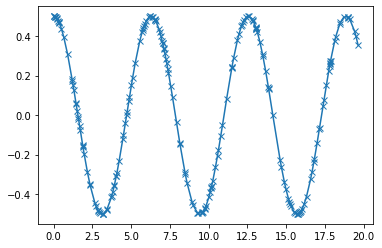

In [68]:
xt = np.sort(np.random.rand(200)*20)
yt = np.cos(xt)/2

plt.plot( xt, yt, "x-" )

In [72]:
def plot(gp):
  x = np.linspace( 0,20,100 )

  mus, sigmas = gp.predict( x.reshape(-1,1) )
  plt.plot( x, mus )

  y_max = mus + np.sqrt(sigmas.flatten())
  y_min = mus - np.sqrt(sigmas.flatten())

  plt.fill_between(x, y_min, y_max, facecolor="lavender" , alpha=0.9 , edgecolor="lavender"  )
  plt.plot(xt, yt)
  plt.show()

# MCMCで学習

tensor([[-470.8630]], dtype=torch.float64, grad_fn=<SubBackward0>) tensor([0.0953, 0.1457, 2.2732], dtype=torch.float64, grad_fn=<CloneBackward>)
tensor([[178.4509]], dtype=torch.float64, grad_fn=<SubBackward0>) tensor([-0.3871, -0.6742, -1.4808], dtype=torch.float64,
       grad_fn=<CloneBackward>)
tensor([[398.8453]], dtype=torch.float64, grad_fn=<SubBackward0>) tensor([-1.5096, -0.6548, -5.2254], dtype=torch.float64,
       grad_fn=<CloneBackward>)
tensor([[409.5589]], dtype=torch.float64, grad_fn=<SubBackward0>) tensor([-1.9020, -0.9385, -7.3670], dtype=torch.float64,
       grad_fn=<CloneBackward>)
tensor([[409.6948]], dtype=torch.float64, grad_fn=<SubBackward0>) tensor([-1.8221, -0.9000, -7.4064], dtype=torch.float64,
       grad_fn=<CloneBackward>)
tensor([[409.6948]], dtype=torch.float64, grad_fn=<SubBackward0>) tensor([-1.8221, -0.9000, -7.4064], dtype=torch.float64,
       grad_fn=<CloneBackward>)
tensor([[409.8096]], dtype=torch.float64, grad_fn=<SubBackward0>) tensor([-1.59

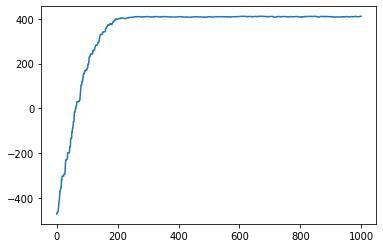

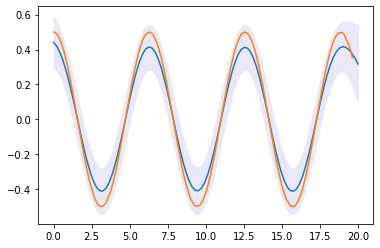

In [104]:
gp = GP(1, "cpu" )
liks = gp.learn( xt.reshape((-1,1)), yt, "mcmc" )

plt.plot( range(len(liks)), liks )
plt.figure()
plot( gp )

# 勾配法で学習

tensor([[475.4149]], device='cuda:0', dtype=torch.float64,
       grad_fn=<NegBackward>) tensor([-0.0100, -0.0100,  2.2926], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
tensor([[280.0060]], device='cuda:0', dtype=torch.float64,
       grad_fn=<NegBackward>) tensor([-0.9321, -0.9085,  1.2945], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
tensor([[98.1842]], device='cuda:0', dtype=torch.float64,
       grad_fn=<NegBackward>) tensor([-1.6131, -0.8860,  0.3150], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
tensor([[-60.5401]], device='cuda:0', dtype=torch.float64,
       grad_fn=<NegBackward>) tensor([-2.0020, -0.6669, -0.6174], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
tensor([[-184.5343]], device='cuda:0', dtype=torch.float64,
       grad_fn=<NegBackward>) tensor([-1.9395, -0.7708, -1.4626], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
tensor([[-268.2644]], device='cuda:0', dtype=torch

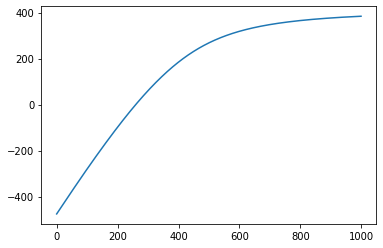

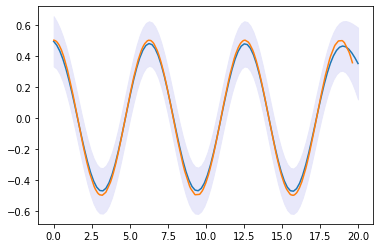

In [103]:
gp = GP(1, "cuda" )
liks = gp.learn( xt.reshape((-1,1)), yt, "gradient" )

plt.plot( range(len(liks)), liks )
plt.figure()
plot( gp )